In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

## Functions

### 1. Functions for data generation

In [2]:
def makeb(d_p,N):
    Bs=list()
    Bs.append(np.zeros(d_p*(N-1)))
    for i in range(N-1):
        Bs.append(np.zeros(d_p*(N-1)))
        x=np.random.normal(0,1,d_p)
        u=np.random.uniform(0,1,1)
        b=u**(1./d_p)*x/np.sqrt(np.sum(x**2))
        Bs[i+1][(i*d_p):((i+1)*d_p)]=b        
    return(Bs)

In [3]:
def makeb2(d_p,N):
    Bs=list()
    x=np.random.normal(0,1,(d_p-1))
    Bs.append(np.zeros(d_p*(N-1)))
    for i in range(N-1):
        Bs.append(np.zeros(d_p*(N-1)))
        Bs[i+1][(i*d_p)]=1.
        Bs[i+1][(i*d_p+1):((i+1)*d_p)]=x  
    return(Bs)
    

In [4]:
def makedata(d_p,N,T,makeb_style,R):
    Bs_list=list()
    errors=list()
    if makeb_style==0:
        for t in range(T):
            Bs=makeb(d_p,N)
            Bs_list.append(Bs)
            errors.append(np.random.multivariate_normal(np.zeros(N),np.eye(N)*(R**2)))
    else:
        for t in range(T):
            Bs=makeb2(d_p,N)
            Bs_list.append(Bs)
            errors.append(np.random.multivariate_normal(np.zeros(N),np.eye(N)*(R**2)))
    return([Bs_list,errors])

### 2. Function for computing the optimal reward and the nonparametric intercept term

In [5]:
def cumul_opt(T,p_min,p_max,Bs_list,mu):
    reward=np.zeros(T)
    vs=np.zeros(T)
    for t in range(T):
        tru_nonzero=np.array([np.dot(b,mu) for b in Bs_list[t][1:]])
        opt_nonzero=np.argmax(tru_nonzero)
        if tru_nonzero[opt_nonzero]<0:
            pt_opt=p_min
        else:
            pt_opt=p_max            
        reward[t]=tru_nonzero[opt_nonzero]*pt_opt
        # compute nu(t), the nonparametric intercept term
        #vs[t]=0 ## Case (i): nu(t)=0
        vs[t]=-reward[t] ## Case (ii): nu(t)=-b_{a^*(t)}^T mu
        #vs[t]=np.log(t+1) ## Case (iii): nu(t)=log(t+1)
    return([np.cumsum(reward),vs])
    

### 3. Functions for algorithms

In [6]:
def standard_TS(T,d,v,Bs_list,errors,mu,vs):
    mu_hat=np.zeros(d+1)
    y=np.zeros(d+1)
    reward=np.zeros(T)
    B=np.eye(d+1)
    for t in range(T):
        V=(v**2)*np.linalg.inv(B)
        mu_tilde=np.random.multivariate_normal(mu_hat,V)[1:]
        est=np.array([np.dot(b,mu_tilde) for b in Bs_list[t]])
        action=np.argmax(est)
        reward[t]=np.dot(Bs_list[t][action],mu)
        newb=np.array([1.]+list(Bs_list[t][action]))
        B=B+np.outer(newb,newb)
        y=y+(np.dot(Bs_list[t][action],mu)+vs[t]+errors[t][action])*newb
        mu_hat=np.linalg.inv(B).dot(y)
    print(np.sqrt(np.dot(mu_hat[1:]-mu,mu_hat[1:]-mu)))
    return(np.cumsum(reward))

In [7]:
def action_centered_TS(T,d,v,p_min,p_max,Bs_list,errors,mu,vs):
    mu_hat=np.zeros(d)
    y=np.zeros(d)
    reward=np.zeros(T)
    reward2=np.zeros(T)
    B=np.eye(d)
    B2=np.eye(d+1)
    y2=np.zeros(d+1)
    for t in range(T):
        V=(v**2)*np.linalg.inv(B)
        mu_tilde=np.random.multivariate_normal(mu_hat,V)
        est=np.array([np.dot(b,mu_tilde) for b in Bs_list[t][1:]])
        action=np.argmax(est)+1
        val_mean=np.dot(Bs_list[t][action],mu_hat)
        val_sd=np.sqrt(np.dot(Bs_list[t][action],V.dot(Bs_list[t][action])))
        pt=np.maximum(p_min,np.minimum((1.-norm.cdf(0.,val_mean,val_sd)),p_max))
        reward[t]=np.dot(Bs_list[t][action],mu)*pt
        choice=np.random.choice([0,1],p=[1-pt,pt])
        if choice==1:
            newb=np.array([1.]+list(Bs_list[t][action]))
            B2=B2+np.outer(newb,newb)
            y2=y2+(np.dot(Bs_list[t][action],mu)+vs[t]+errors[t][action])*newb
            intercept=np.linalg.inv(B2).dot(y2)[0]
            y=y+(1-pt)*(-intercept+np.dot(Bs_list[t][action],mu)+vs[t]+errors[t][action])*Bs_list[t][action]
            reward2[t]=np.dot(Bs_list[t][action],mu)
        else:
            newb=np.array([1.]+list(Bs_list[t][0]))
            B2=B2+np.outer(newb,newb)
            y2=y2+(vs[t]+errors[t][0])*newb
            intercept=np.linalg.inv(B2).dot(y2)[0]
            y=y+(-pt)*(-intercept+vs[t]+errors[t][0])*Bs_list[t][action]
        B=B+pt*(1-pt)*np.outer(Bs_list[t][action],Bs_list[t][action])
        mu_hat=np.linalg.inv(B).dot(y)
    print(np.sqrt(np.dot(mu_hat-mu,mu_hat-mu)))
    return(np.cumsum(reward))        

In [8]:
def Proposed_TS(T,d,v,N,Bs_list,errors,mu,vs):
    mu_hat=np.zeros(d)
    y=np.zeros(d)
    reward=np.zeros(T)
    B=np.eye(d)
    B2=np.eye(d+1)
    y2=np.zeros(d+1)
    intercept=0
    for t in range(T):
        V=(v**2)*np.linalg.inv(B)
        mu_tilde=np.random.multivariate_normal(mu_hat,V)
        est=np.array([np.dot(b,mu_tilde) for b in Bs_list[t]])
        action=np.argmax(est)
        mu_mc=np.random.multivariate_normal(mu_hat,V,1000)
        est_mc=list((np.dot(Bs_list[t],mu_mc.T)).T)
        ac_mc=list(np.argmax(est_mc,axis=1))
        pi_est=np.array([float(ac_mc.count(n))/len(ac_mc) for n in range(N)])
        b_mean=np.dot(np.transpose(np.array(Bs_list[t])),pi_est)
        B=B+2*np.outer(Bs_list[t][action]-b_mean,Bs_list[t][action]-b_mean)
        B=B+2*np.dot(np.dot(np.transpose(Bs_list[t]),np.diag(pi_est)),Bs_list[t])-2*np.outer(b_mean,b_mean)
        y=y+4*(Bs_list[t][action]-b_mean)*(-intercept+vs[t]+errors[t][action]+np.dot(Bs_list[t][action],mu))
        reward[t]=np.dot(Bs_list[t][action],mu)
        mu_hat=np.linalg.inv(B).dot(y)
        newb=np.array([1.]+list(Bs_list[t][action]))
        B2=B2+np.outer(newb,newb)
        y2=y2+(np.dot(Bs_list[t][action],mu)+vs[t]+errors[t][action])*newb
        intercept=np.linalg.inv(B2).dot(y2)[0]
    print(np.sqrt(np.dot(mu_hat-mu,mu_hat-mu)))
    return(np.cumsum(reward))        

In [9]:
def Bose(T,d,v,N,Bs_list,errors,mu,vs):
    mu_hat=np.zeros(d)
    y=np.zeros(d)
    reward=np.zeros(T)
    B=np.eye(d)
    B2=np.eye(d+1)
    y2=np.zeros(d+1)
    intercept=0
    for t in range(T):
        survivors=[]
        for i in range(N):
            fail=False
            for j in range(N):
                vec=Bs_list[t][j]-Bs_list[t][i]
                tmp=np.dot(vec,mu_hat)-v*np.sqrt(np.dot(vec,np.linalg.inv(B).dot(vec)))
                if tmp>0:
                    fail=True
                    break
            if not fail:
                survivors.append(i)
        if len(survivors)==1:
            action=survivors[0]
        if len(survivors)>=2:
            action=np.random.choice(survivors)
            new_list=[Bs_list[t][k] for k in survivors]
            pi_est=np.ones(len(survivors))*1./len(survivors)
            b_mean=np.dot(np.transpose(np.array(new_list)),pi_est)
            B=B+np.outer(Bs_list[t][action]-b_mean,Bs_list[t][action]-b_mean)
            y=y+(Bs_list[t][action]-b_mean)*(-intercept+vs[t]+errors[t][action]+np.dot(Bs_list[t][action],mu))
            mu_hat=np.linalg.inv(B).dot(y)
            
        reward[t]=np.dot(Bs_list[t][action],mu)    
        newb=np.array([1.]+list(Bs_list[t][action]))
        B2=B2+np.outer(newb,newb)
        y2=y2+newb*(vs[t]+errors[t][action]+np.dot(Bs_list[t][action],mu))
        intercept=np.linalg.inv(B2).dot(y2)[0]
    print(np.sqrt(np.dot(mu_hat-mu,mu_hat-mu)))
    return(np.cumsum(reward))            

## Simulation Settings

In [10]:
simul_n=50 # number of simulations
T=10000 # number of time steps
R=0.1
d_p=10 # d prime
N=2 # number of actions
d=d_p*(N-1) # dimension of mu
p_min=0.; p_max=1. # p_min and p_max for action-centered TS algorithm
makeb_style=0
mu=2*np.array([-0.275,0.333,-0.045,-0.116,0.122,0.275,-0.333,0.045,0.116,-0.122])

### 1. Selection of tuning parameter

In [11]:
# Candidate values of tuning parameter for each algorithm.

Vstd=[0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02]
Vac=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2]
Vprop=[0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.2,0.3,0.4]
Vbose=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2]

In [12]:
# Lists to store the median regret values obtained by each algorithm for each candidate value of tuning parameter.

valStd=[]
valAC=[]
valProp=[]
valBose=[]

In [13]:
Data_list=[]

In [14]:
np.random.seed(1)

for simul in range(simul_n):
    Data_list.append(makedata(d_p=d_p,N=N,T=T,makeb_style=makeb_style,R=R))


for tp in range(11):
    
    cumulated_opt=list()
    cumulated_reward_Std=list()
    cumulated_reward_AC=list()
    cumulated_reward_Prop=list()
    cumulated_reward_Bose=list()

    cumulated_regret_Std=list()
    cumulated_regret_AC=list()
    cumulated_regret_Prop=list()
    cumulated_regret_Bose=list()

    for simul in range(simul_n):
    
        Data=Data_list[simul]
        Bs_list=Data[0]
        errors=Data[1]
    
        CO=cumul_opt(T=T,p_min=0.,p_max=1.0,Bs_list=Bs_list,mu=mu)
        cumulated_opt.append(CO[0])
        vs=CO[1]
        cumulated_reward_Std.append(standard_TS(T=T,d=d,v=Vstd[tp],Bs_list=Bs_list,errors=errors,mu=mu,vs=vs))
        cumulated_reward_AC.append(action_centered_TS(T=T,d=d,v=Vac[tp],p_min=p_min,p_max=p_max,Bs_list=Bs_list,errors=errors,mu=mu,vs=vs))
        cumulated_reward_Prop.append(Proposed_TS(T=T,d=d,v=Vprop[tp],N=N,Bs_list=Bs_list,errors=errors,mu=mu,vs=vs))
        cumulated_reward_Bose.append(Bose(T=T,d=d,v=Vbose[tp],N=N,Bs_list=Bs_list,errors=errors,mu=mu,vs=vs))
        
        cumulated_regret_Std.append(cumulated_opt[simul]-cumulated_reward_Std[simul])
        cumulated_regret_AC.append(cumulated_opt[simul]-cumulated_reward_AC[simul])
        cumulated_regret_Prop.append(cumulated_opt[simul]-cumulated_reward_Prop[simul])
        cumulated_regret_Bose.append(cumulated_opt[simul]-cumulated_reward_Bose[simul])
    
        print(simul)
        
    valStd.append(np.median(cumulated_regret_Std,axis=0)[9999])
    valAC.append(np.median(cumulated_regret_AC,axis=0)[9999])
    valProp.append(np.median(cumulated_regret_Prop,axis=0)[9999])
    valBose.append(np.median(cumulated_regret_Bose,axis=0)[9999])
    
    

1.2864131292487149
0.8560643234181339
0.3821459929716942
0.8989133721014686
0
1.291694879711148
0.8041276500016562
0.33494949221512976
0.8115397566048413
1
1.2836000155559717
0.9154592698194514
0.2792622185802374
0.9148089744479742
2
1.2874627828036858
0.8134567014315686
0.5339667091291304
0.827930685694583
3
1.28521313175606
0.7946602737322772
0.34516991657349305
0.8478870802467424
4
1.2786814880245616
0.8625467255383237
0.3315843716068134
0.8539198413312189
5
1.2876350847901534
0.9113323918290784
0.4346519095301032
0.874256913537004
6
1.2755649506025983
0.8273294202555603
0.07086580570410864
0.8122178713055135
7
1.2869300048933494
0.8759560190782267
0.5001274247066894
0.8466551595172442
8
1.286021171024984
0.8598688594786962
0.2910327806930119
0.8440566288620068
9
1.2830669129341414
0.9081920448617541
0.3896818067270333
0.8186883102714553
10
1.287022475913591
0.9258098190573261
0.35742476712603033
0.8704993087138311
11
1.27965489484572
0.8581545718622116
0.33724775233793947
0.8079823

0.78492314568023
0.5311609530503635
0.7964125068422611
4
1.2785043023174536
0.7796061257799504
0.2952050346879143
0.7962412379559528
5
1.2873664441770527
0.7607795566008532
0.242115916726944
0.7845780242606365
6
1.2770762816770787
0.6740023392068288
0.07379551518523816
0.7271917710041517
7
1.2863356887201245
0.8321366227836293
0.466773138959318
0.7350025111421794
8
1.2867772832104003
0.8127850765527913
0.128254730682046
0.8447239538847469
9
1.2837827043208474
0.8552215952850858
0.3469990145790748
0.8408116555514309
10
1.2850472135272006
0.6450245835697312
0.5082215023056463
0.8216150538533022
11
1.2790184633213226
0.6781737081091317
0.258558529951167
0.8497260741775198
12
1.2786241861852612
0.7357302021624633
0.3847673320847762
0.7839004318707692
13
1.285035216878784
0.8001214367019212
0.32139529733958844
0.7254153930608406
14
1.2863759662357719
0.8160407689439195
0.45107318188191664
0.8464402996006339
15
1.2935617467011948
0.8371469853091369
0.2322079808266656
0.7889003086066604
16
1.

0.25423535632120586
0.7427699104069675
8
1.2846593318750041
0.7381674633798633
0.34621384281816897
0.7129463561292542
9
1.282797519553154
0.5028702581679335
0.17075897635976975
0.7083187217675406
10
1.2855449687837097
0.7329030268639983
0.2422430100736643
0.7410647442635037
11
1.2790764024224468
0.6460539843504489
0.23761217332799314
0.8129226518503304
12
1.2797586464954207
0.7448917140864859
0.34257245161540556
0.7121256460933764
13
1.282371753688376
0.6713586429478969
0.4097714942279686
0.7916348409638843
14
1.286093492929528
0.6873324610647406
0.5623145217137878
0.761820980835258
15
1.292990073028464
0.7007301939452684
0.5358062044145449
0.721515782730679
16
1.284614611643717
0.7775047683056423
0.18593351625569648
0.8069578036763413
17
1.2816550667394788
0.6845781203482807
0.4501092363350433
0.831184531143059
18
1.2815920196353212
0.71760137560051
0.36645677122274545
0.7464905225050982
19
1.276082462447204
0.7600078369947659
0.3693217632975188
0.729740316249824
20
1.2920980689901231

1.2797277281091441
0.5375855845351608
0.3189809426267578
0.7170336622597312
13
1.2853334229225575
0.6836582837771468
0.4863965092305668
0.7111464793786054
14
1.2845286627679773
0.7125818990126505
0.12984643089927791
0.7033530784793113
15
1.292351209873878
0.6500885095206248
0.2891111435615509
0.6758039581009899
16
1.2857542701191358
0.6169474215525984
0.23265569907195233
0.6848061678939045
17
1.2807475525077436
0.6425831554023025
0.2619235488161347
0.6994594035272043
18
1.281977834591106
0.7333183131060238
0.2354745784878242
0.7098196830883945
19
1.2746651835998688
0.7180724618795358
0.30554502721680327
0.6289244696462564
20
1.290984136374518
0.6704063686933814
0.20657687214941162
0.747501305964736
21
1.2874382238082298
0.5867819076068053
0.15407868774783332
0.6811023412136831
22
1.2858777202130973
0.6628078824339839
0.42606199722236926
0.724341475707755
23
1.280983750973743
0.6577114123764686
0.4270298090664283
0.7118151432383811
24
1.2788657331852857
0.7642472076656753
0.318093330202

1.2863228849381465
0.6286222457875916
0.3023741055256407
0.7283271337488801
17
1.2810761610255141
0.5653874300309853
0.10176413342313585
0.6803838160382325
18
1.281334188262075
0.6513999363147251
0.14228758403199754
0.6474911614339284
19
1.277027935734344
0.48179964440915396
0.5034608696774098
0.6648741486444711
20
1.2911942891250507
0.5952854588521412
0.3725787188223787
0.663657975762201
21
1.2866978217266827
0.5012254250058844
0.2224218602995713
0.6340563398176269
22
1.2842125876530113
0.4351684843607348
0.20949311563307554
0.6939812606028491
23
1.2806778497762823
0.6485584921579263
0.22970742501000693
0.6652491050689553
24
1.2776372537232714
0.5562933634209848
0.3090244008764223
0.7134036206806577
25
1.2818170531175643
0.6281709909281515
0.16328754402817403
0.6769525062216282
26
1.2940527580468224
0.43232649812936985
0.12077564903281286
0.7065182260879432
27
1.2778847011328325
0.6714061369771915
0.4003429444178342
0.7723140518155489
28
1.2813341690800424
0.5994503362491159
0.4127855

0.41634490456799067
20
1.2877299726143305
0.36116864648653046
0.07475988010776947
0.4737195094267772
21
1.2867595971271162
0.37116304656123333
0.18200999431367607
0.5137052543420033
22
1.283613088577671
0.36392054967696313
0.13288379513068196
0.43864873870810384
23
1.2786356240217225
0.4076263672027661
0.15153032857928941
0.4962703071826403
24
1.2788197482465948
0.35049988475731647
0.2923018015137877
0.5210049923838623
25
1.281887215397441
0.34005224080769786
0.24523594964669487
0.5046693353566374
26
1.2924185006081144
0.4213801291874088
0.0852591318255191
0.4468228489499013
27
1.2752213917892001
0.37637334249933135
0.06511956949322459
0.5784814152497304
28
1.2814508060604242
0.3586184127197053
0.1359555338594383
0.4567007167518916
29
1.2856868508002277
0.4958462702268547
0.23168000014746645
0.5250616884249758
30
1.2768872346856543
0.25915461927104855
0.07644641601704162
0.4934367499357384
31
1.287091135528857
0.4149976706372181
0.11679161508591417
0.5349466920541958
32
1.2890174763010

In [15]:
np.round(valStd,2)

array([58.  , 58.18, 57.17, 57.56, 57.17, 57.45, 58.85, 58.19, 57.43,
       58.67, 60.23])

In [16]:
np.round(valAC,2)

array([33.72, 23.79, 21.72, 21.1 , 21.43, 21.91, 22.67, 22.23, 23.72,
       23.84, 34.84])

In [17]:
np.round(valProp,2)

array([22.53, 19.78, 19.37, 18.99, 17.55, 17.84, 18.21, 17.36, 19.5 ,
       22.88, 26.69])

In [18]:
np.round(valBose,2)

array([35.14, 25.58, 21.9 , 21.02, 21.81, 22.42, 23.12, 24.02, 25.12,
       26.57, 41.64])

### 2. Simulation

In [19]:
cumulated_opt=list()
cumulated_reward_Std=list()
cumulated_reward_AC=list()
cumulated_reward_Prop=list()
cumulated_reward_Bose=list()

cumulated_regret_Std=list()
cumulated_regret_AC=list()
cumulated_regret_Prop=list()
cumulated_regret_Bose=list()


In [20]:
Data_list=[]

In [21]:

np.random.seed(1)

for simul in range(simul_n):
    Data_list.append(makedata(d_p=d_p,N=N,T=T,makeb_style=makeb_style,R=R))


for simul in range(simul_n):
    
    Data=Data_list[simul]
    Bs_list=Data[0]
    errors=Data[1]
    
    CO=cumul_opt(T=T,p_min=0.,p_max=1.0,Bs_list=Bs_list,mu=mu)
    cumulated_opt.append(CO[0])
    vs=CO[1]
    cumulated_reward_Std.append(standard_TS(T=T,d=d,v=0.005,Bs_list=Bs_list,errors=errors,mu=mu,vs=vs))
    cumulated_reward_AC.append(action_centered_TS(T=T,d=d,v=0.04,p_min=p_min,p_max=p_max,Bs_list=Bs_list,errors=errors,mu=mu,vs=vs))
    cumulated_reward_Prop.append(Proposed_TS(T=T,d=d,v=0.12,N=N,Bs_list=Bs_list,errors=errors,mu=mu,vs=vs))
    cumulated_reward_Bose.append(Bose(T=T,d=d,v=0.04,N=N,Bs_list=Bs_list,errors=errors,mu=mu,vs=vs))
    
    cumulated_regret_Std.append(cumulated_opt[simul]-cumulated_reward_Std[simul])
    cumulated_regret_AC.append(cumulated_opt[simul]-cumulated_reward_AC[simul])
    cumulated_regret_Prop.append(cumulated_opt[simul]-cumulated_reward_Prop[simul])
    cumulated_regret_Bose.append(cumulated_opt[simul]-cumulated_reward_Bose[simul])
    
    print(simul)
    

1.28435538431884
0.7074215987514625
0.36866881309664656
0.7927990493641813
0
1.2889715611181534
0.6638275604511114
0.22980589511867947
0.7621635906212697
1
1.2837000815830792
0.8150484323261435
0.48946129406691047
0.7563753080700333
2
1.286190443974415
0.6984683049188813
0.5627267738643594
0.8316019865093235
3
1.2839212223811656
0.7370314187940185
0.36404528943192965
0.7412957186852358
4
1.2797312172135833
0.6781562303691693
0.3032074875794648
0.7415797922970555
5
1.2865796697538348
0.8114329155976502
0.22816213693379533
0.7493030473754267
6
1.2759520819026797
0.6265472702015128
0.5989425007690669
0.7993428886104689
7
1.2863890139185288
0.7282255096372595
0.15883932734733058
0.7833337096713971
8
1.2855748030815919
0.6839300347649335
0.44241193357264713
0.8352695224099111
9
1.2825834973315338
0.7118844822815952
0.11158331057258639
0.6617156439661732
10
1.2857192506622686
0.7821955348864406
0.25033600495592956
0.772927952853163
11
1.2795944137334814
0.6873284392626668
0.2003746147559044


In [22]:
np.median(cumulated_regret_Std,axis=0)[9999]

57.42924127532319

In [23]:
np.median(cumulated_regret_AC,axis=0)[9999]

21.32809096563892

In [24]:
np.median(cumulated_regret_Prop,axis=0)[9999]

17.367422163412925

In [25]:
np.median(cumulated_regret_Bose,axis=0)[9999]

20.603071206039772

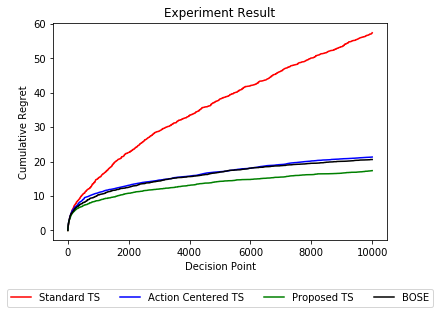

In [26]:
steps=np.arange(1,T+1)

plt.plot(steps,np.median(cumulated_regret_Std,axis=0),'r',label='Standard TS')
plt.plot(steps,np.median(cumulated_regret_AC,axis=0),'b',label='Action Centered TS')
plt.plot(steps,np.median(cumulated_regret_Prop,axis=0),'g',label='Proposed TS')
plt.plot(steps,np.median(cumulated_regret_Bose,axis=0),'k',label='BOSE')


plt.xlabel('Decision Point')
plt.ylabel('Cumulative Regret')
plt.title('Experiment Result')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.2),fancybox=True,ncol=5)
plt.show()

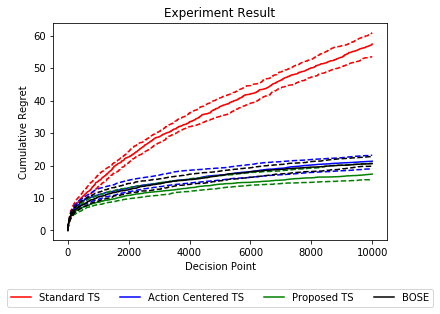

In [27]:
steps=np.arange(1,T+1)

plt.plot(steps,np.median(cumulated_regret_Std,axis=0),'r',label='Standard TS')
plt.plot(steps,np.percentile(cumulated_regret_Std,25,axis=0),'r',linestyle='--')
plt.plot(steps,np.percentile(cumulated_regret_Std,75,axis=0),'r',linestyle='--')

plt.plot(steps,np.median(cumulated_regret_AC,axis=0),'b',label='Action Centered TS')
plt.plot(steps,np.percentile(cumulated_regret_AC,25,axis=0),'b',linestyle='--')
plt.plot(steps,np.percentile(cumulated_regret_AC,75,axis=0),'b',linestyle='--')

plt.plot(steps,np.median(cumulated_regret_Prop,axis=0),'g',label='Proposed TS')
plt.plot(steps,np.percentile(cumulated_regret_Prop,25,axis=0),'g',linestyle='--')
plt.plot(steps,np.percentile(cumulated_regret_Prop,75,axis=0),'g',linestyle='--')

plt.plot(steps,np.median(cumulated_regret_Bose,axis=0),'k',label='BOSE')
plt.plot(steps,np.percentile(cumulated_regret_Bose,25,axis=0),'k',linestyle='--')
plt.plot(steps,np.percentile(cumulated_regret_Bose,75,axis=0),'k',linestyle='--')

plt.xlabel('Decision Point')
plt.ylabel('Cumulative Regret')
plt.title('Experiment Result')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.2),fancybox=True,ncol=5)
plt.show()